In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive"

 Code  'Colab Notebooks'   contents   KT4  'KT4 subset'


In [3]:
!pwd

/content


In [4]:
import pandas as pd
import glob
import os
import numpy as np
from datetime import datetime

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [6]:
path = "drive/My Drive/KT4 subset"
csv_files = glob.glob(os.path.join(path, "*.csv"))

content_path = "drive/My Drive/contents"
questions = pd.read_csv(content_path +  '/questions.csv')
payments = pd.read_csv(content_path +  '/payments.csv')
lectures = pd.read_csv(content_path +  '/lectures.csv')
coupons = pd.read_csv(content_path +  '/coupons.csv')




---


## ***WHO ARE THE USERS?***

---



## **1.a.** Overall practice volume and performance

**Parsing user data**

- Fetched unique user identifiers from filenames
- calculated number of questions answered by counting *action_type = respond*
- Calculated percentage of correct anwers by making use of *questions.csv* from additional contents

In [7]:
user_list = []
df_key = questions[['question_id', 'correct_answer']]

for f in csv_files:
  userid = (os.path.splitext(os.path.basename(f))[0]) # user identifier
  user_data = pd.read_csv(f)
  responded = (user_data[pd.notnull(user_data["user_answer"]) & ('respond' in set(user_data['action_type']))])

  df_verify =  pd.merge(responded, df_key, left_on='item_id', right_on='question_id', how='inner')
  df_verify['verify'] = (df_verify['user_answer'] == df_verify['correct_answer']).astype(int)
  correctness = (len(df_verify[df_verify['verify'] == 1]) / len(df_verify))

  user_list.append([userid, len(responded.index), np.round(correctness, 2)])

In [11]:
df_user_table = pd.DataFrame(user_list, columns=['user', 'no_of_responses', 'perc_correct_responses'])
# df_user_table.sort_values('perc_correct_responses', ascending = False, inplace = True)
df_user_table.head(10)

,user,no_of_responses,perc_correct_responses
0,u835,179,0.52
1,u821,1879,0.32
2,u82,2437,0.68
3,u69,11,0.27
4,u148,26,0.19
5,u55,323,0.60
6,u612,23,0.43
7,u174,396,0.58
8,u160,11,0.36
9,u606,465,0.46


**Additional Information**

In [9]:
val_count = df_verify['verify'].value_counts()
val_count.head()

1    3047
0    1937
Name: verify, dtype: int64

## **1.b.** Learning **activity**

In [72]:
user_list_b = []
df_lectures = lectures[['lecture_id', 'video_length']]

for f in csv_files:
  userid = (os.path.splitext(os.path.basename(f))[0]) # user identifier
  user_data = pd.read_csv(f)
  
  lectures_watched = user_data[user_data['item_id'].str.startswith('l')]
  exp_read = user_data[user_data['item_id'].str.startswith('e')]
  premium = user_data[user_data['item_id'].str.startswith('p')]

  #ignoring empty users
  if (len(lectures_watched.index) == 0) & ((len(exp_read.index) == 0)):
    continue

  #getting count of platform specific actions
  plat_count = pd.concat([lectures_watched, exp_read], axis=0)['platform'].value_counts()
  plat_pref = plat_count.index.tolist()[0];

  #check for premium service usage
  premium_used = (len(premium.index) > 0)

  user_list_b.append([userid, len(lectures_watched.index), len(exp_read.index), plat_pref, premium_used])

In [120]:
#Adding learning medium preference as a new column
df_user_table_b = pd.DataFrame(user_list_b, columns=['user', 'lectures_watched', 'explanations_read', 'plat_pref', 'premium_used'])
df_user_table_b['learning_medium_pref'] = np.where(df_user_table_b['lectures_watched'] > df_user_table_b['explanations_read'], 'video', 'text')

#Adding a column to suggest total actions a student has taken towards learning
df_user_table_b['total_study_actions'] = df_user_table_b['explanations_read'] + df_user_table_b['lectures_watched']
#Creating 3 effort categories based on actions that suggest student studying
df_user_table_b['effort_level'] = pd.qcut(df_user_table_b['total_study_actions'], 3, labels = ["Low", "Medium", "High"])


## **Table 1**

In [122]:
table_1 = df_user_table.merge(df_user_table_b, on='user', how='inner')
table_1

,user,no_of_responses,perc_correct_responses,lectures_watched,explanations_read,plat_pref,premium_used,learning_medium_pref,total_study_actions,effort_level
0,u835,179,0.52,24,288,mobile,False,text,312,Medium
1,u821,1879,0.32,50,626,mobile,True,text,676,Medium
2,u82,2437,0.68,856,4244,mobile,True,text,5100,High
3,u148,26,0.19,0,28,mobile,False,text,28,Low
4,u55,323,0.60,8,576,mobile,True,text,584,Medium
...,...,...,...,...,...,...,...,...,...,...
795,u637,586,0.58,176,858,mobile,True,text,1034,Medium
796,u804,546,0.37,169,548,web,True,text,717,Medium
797,u810,949,0.73,76,1478,web,True,text,1554,High
798,u838,30,0.73,4,76,mobile,False,text,80,Low


## **PLOTS**

**Plot for Premium v/s Non-Premium users**

In [115]:
premium_info = pd.DataFrame(table_1['premium_used'].value_counts())

fig = go.Figure(data=[go.Pie(labels=['Premium', 'Non-Premium'], values=premium_info.premium_used)])
fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(
    title="Premium v/s Non-Premium users")
fig.show()

**Plot for showcasing study effort and the mean answer correctness associated with the effort**

In [121]:
#Creating a dataframe with effort category and the mean effort for each category
Low = table_1[table_1['effort_level'] == 'Low']
Medium = table_1[table_1['effort_level'] == 'Medium']
High = table_1[table_1['effort_level'] == 'High']

#calcuating mean correctness for each category
data_effort = [['Low', Low['perc_correct_responses'].mean()], ['Medium', Medium['perc_correct_responses'].mean()], ['High', High['perc_correct_responses'].mean()]]

df_effort = pd.DataFrame(data_effort, columns=['Effort_level', 'Mean'])
df_effort

,Effort_level,Mean
0,Low,0.512697
1,Medium,0.513835
2,High,0.507678


I was surprised to find that the difference in mean value for each effort category is almost non-existent.
I expected the high effort category to have a better mean answer correctness value and vice-versa.

In [118]:
#Plotting the dataframe
fig = go.Figure(
    data=[go.Bar(x = df_effort['Effort_level'], y=df_effort['Mean'])],
    layout_title_text="Effort v/s Correct Answers"
)
fig.update_traces(textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.show()

**Plot for Lectures watched vs Explanations read**

Helps understand the learning medium students are using to learn



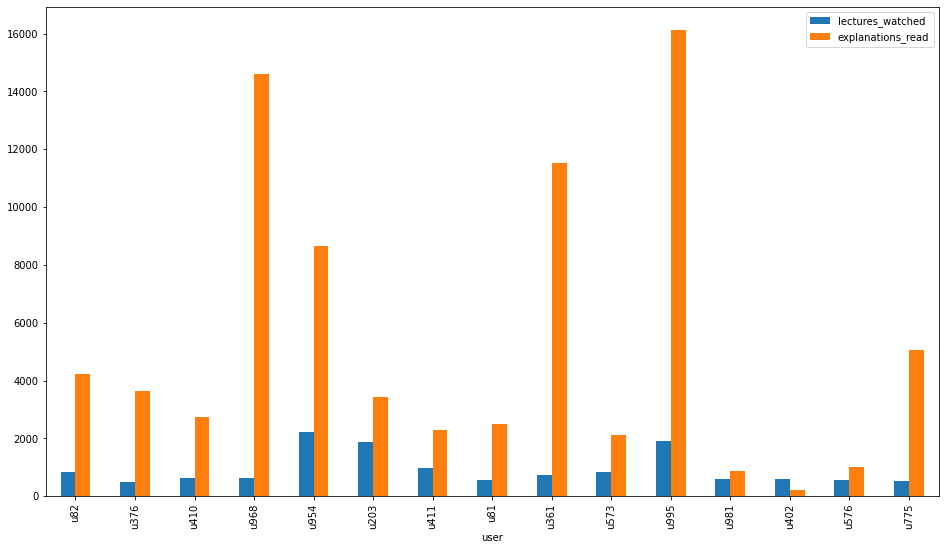

In [191]:
df_user_table_b_viz = df_user_table_b[(df_user_table_b['explanations_read'] > 100) & (df_user_table_b['lectures_watched'] > 500)]
plt.rcParams["figure.figsize"] = [16,9]
df_user_table_b_viz.head(15).plot(x="user", y=["lectures_watched", "explanations_read"], kind="bar")
plt.show()